# With sWeights: `common_B0toDstDs`
# Without sWeights: `common_fixedTails_MC_cor`


# Fit the complete data (With sWeights and without sWeights)
- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
        - **FINAL CHOICE: fixed tail parameters**
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)

Those two fits are not simultaneous

## Import

In [1]:
import zfit
import json
import numpy as np
import timeit


from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, retrieve_pickle, load_saved_root, json_to_latex_table, retrieve_params
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import launch_fit, define_zparams, save_params, sum_crystalball
from variables import name_params, name_params_B0toDstDs

Welcome to JupyROOT 6.22/02


## Load

In [2]:
# Mean of the distribution of the partially reconstructed data
# used a starting value
mu2_p = retrieve_params('all_data_strip', name_folder='data_strip_p')['mu2']
print(mu2_p)

5057.699255828802


In [3]:
df = load_data(years, magnets, type_data='common', vars=['B0_M','tau_M'],
                            cut_DeltaM=True)

/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2015_down.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_up.root
/eos/lhcb/wg/semileptonic/RXcHad/B02Dsttaunu/Run2/ntuples//common/data/data_90000000_2016_down.root
cut on DeltaM has removed 425088 over 935261 events


In [2]:
name_data = 'common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt'
name_data_B0toDstDs = 'common_B0toDstDs_mu2Free'
name_data_Dstto3pi = 'common_Dstto3pi'

#name_data_MC = 'MC_cor'
name_data_MC = 'MC_twoCB'
name_data_Kpipi = 'data_KPiPi_2'

## Fit on weighted `B0_M` with `|tau_M-1969|<50`

### Data

In [5]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M

df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

In [6]:
low_B0Ds = 5150.
high_B0Ds = 5360.
weights = load_saved_root(name_data_Dstto3pi, ['sWeight'], name_folder='common')['sWeight']


/afs/cern.ch/user/c/correian/bd2dst3pi/output//root/common/common_Dstto3pi.root


### Distributions

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/histogram.py:50: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_common_B0toDstDs_mu2Free


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (2 MeV/$c^2$)'>)

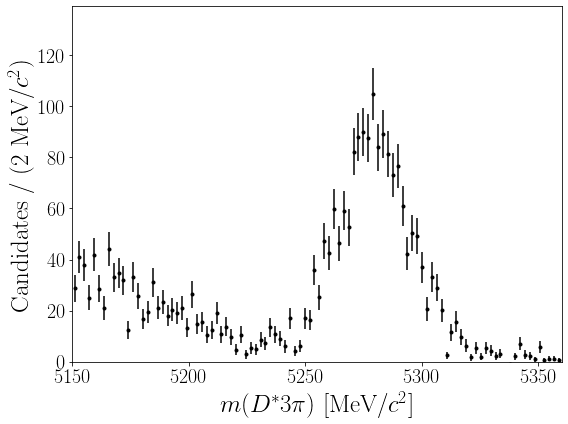

In [7]:
h.plot_hist_particle({name_data_B0toDstDs:df_Ds},'B0_M',
              low = low_B0Ds, high = high_B0Ds,
              n_bins = 100, mode_hist = False, colors='black', weights=weights)

### Starting values

In [ ]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

n_sig_k = 1600
n_bkg_k = 200
n_bkg2_k = 800

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': 5279.                         , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': 15.                           , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': -0.000001                     , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
#     'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#     'sigma2_B0Ds'   :{ 'value': 80.                           , 'low': 50.            , 'high': 90.                  , 'floating': True},
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5200.                , 'floating': True},
    'sigma2_B0Ds'   :{ 'value': 80.                           , 'low': 10.            , 'high': 90.                  , 'floating': True},    
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}

### Observables and variables

In [ ]:
obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

zparams_B0Ds = define_zparams(initial_values_B0Ds)

### PDFs

In [ ]:
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=weights)

### Fitting

In [ ]:
start = timeit.default_timer()
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

Result of the 1st fit

    ------------------------------------------------------------------
    | FCN = -4938                   |     Ncalls=163 (163 total)     |
    | EDM = 0.000956 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
    n_bkg_B0Ds        200.8     +/-      73  -     37   +1.6e+02       False
    n_bkg2_B0Ds       812.9     +/-      60  -1.5e+02   +     41       False
    mu_B0Ds            5280     +/-    0.59  -   0.45   +   0.44       False
    sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
    lambda_B0Ds  -2.289e-07     +/- 8.2e-05  - 0.0059   +   0.02       False
    sigma2_B0Ds       76.21     +/-       4  -    4.6   +    3.4       False
    Time to do the fit:  28.78929978515953

Result of the 2nd fit

    ------------------------------------------------------------------
    | FCN = -4938                   |      Ncalls=99 (99 total)      |
    | EDM = 0.000371 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1564     +/-      45  -     45   +     45       False
    n_bkg_B0Ds        200.1     +/-      72  -     36   +1.6e+02       False
    n_bkg2_B0Ds         813     +/-      59  -1.4e+02   +     41       False
    mu_B0Ds            5280     +/-    0.59  -   0.44   +   0.45       False
    sigma_B0Ds        15.24     +/-    0.54  -   0.38   +   0.39       False
    lambda_B0Ds  -1.241e-07     +/- 2.7e-05  - 0.0059   +  0.016       False
    sigma2_B0Ds       76.26     +/-       4  -    4.6   +    3.3       False
    Time to do the fit:  26.363226884044707



In [ ]:
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_B0toDstDs+'_details', name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=weights,
                       params=params_B0Ds,name_params=name_params_B0toDstDs,
                       colWidths=[0.05,0.01,0.05,0.04], show_chi2=True,
                       fontsize_res = 18.,
                       fontsize_leg=20)

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/histogram.py:50: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


Number of d.o.f. in the model:  8
Reduced chi2:  1.1118000514297919


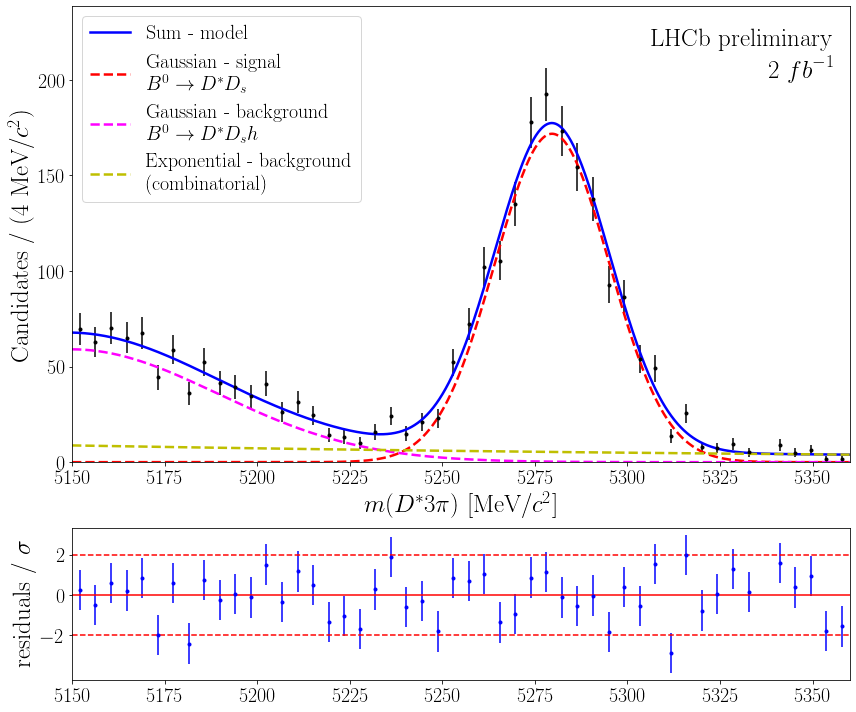

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_fixedTails_MC_cor_B0toDstDsWithmu2Free/B0_M_common_B0toDstDs_mu2Free_50_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

In [15]:
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 50,mode_hist = False,
                       name_data = name_data_B0toDstDs+'_50', name_folder=name_data,
                       colors=['b','r','magenta','y'], weights=weights,
                       colWidths=[0.05,0.01,0.05,0.04],
                       fontsize_res = 18., pos_text_LHC='right',
                       fontsize_leg=20)

In [16]:
save_params(params_B0Ds, name_data_B0toDstDs, True, name_folder=name_data_B0toDstDs)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_B0toDstDs_mu2Free/common_B0toDstDs_mu2Free_params.json


In [17]:
json_to_latex_table(name_data_B0toDstDs, name_data_B0toDstDs, name_params_B0toDstDs)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_B0toDstDs_mu2Free/common_B0toDstDs_mu2Free_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$\lambda_{B,c}$&$-0.0038\pm0.0087$\\
\hline
$\mu_{B, D^* D_s h}$&$5150\pm13$\\
\hline
$\mu_S$&$5279.63\pm0.60$\\
\hline
$n_{B, D^* D_s h}$&$(6.9\pm2.2)\times 10^2$\\
\hline
$n_{B,c}$&$(3.0\pm2.6)\times 10^2$\\
\hline
$n_S$&$1582\pm62$\\
\hline
$\sigma_{B, D^* D_s h}$&$39.5\pm8.7$\\
\hline
$\sigma_S$&$15.43\pm0.63$\\
\hline
\end{tabular}


## Fit on the full `B0_M`

In [5]:
low = 5150.
high = 5550.

### Data

In [6]:
data_KPiPi_params = retrieve_params(name_data_Kpipi, name_folder='data_KPiPi')    
   
for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
    data_KPiPi_params[var] = data_KPiPi_params[var]*1000
    data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000    

data_B0Ds_params = retrieve_params(name_data_B0toDstDs, name_folder=name_data_B0toDstDs)   
MC_param_results = retrieve_params(name_data_MC, name_folder='MC')

### Distribution

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>)

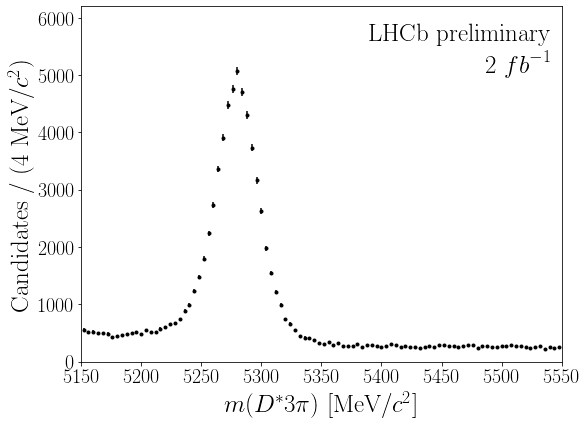

In [7]:
h.plot_hist_particle({name_data:df},'B0_M',
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black', pos_text_LHC='right')

### Initial values

In [8]:
5279.53-134.9766

5144.5534

In [9]:
print(MC_param_results)

{'alphaL_MC': 1.7586158491959407, 'alphaL_MC_err': 0.07231196791658683, 'alphaR_MC': -2.1869530658322134, 'alphaR_MC_err': 0.1604507221288745, 'frac_MC': 0.642096780523404, 'frac_MC_err': 0.048442145773557356, 'mu_MC': 5281.043999315937, 'mu_MC_err': 0.12735098184081645, 'nL_MC': 1.238047575893823, 'nL_MC_err': 0.13711286160459943, 'nR_MC': 2.999003249340586, 'nR_MC_err': 1.1641464857366322, 'sigmaL_MC': 13.05429625967924, 'sigmaL_MC_err': 0.3528542995472201, 'sigmaR_MC': 21.265914220520735, 'sigmaR_MC_err': 0.7886373126322704}


In [10]:
n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = 53000
n_bkg_k = 28000
n_bkg2_k = 500
r_bkgK_k = 0.025

# n_sig        53390     +/- 5.4e+02       False
# n_bkg2       619.1     +/- 1.3e+02       False
# r_bkgK     0.07255     +/-  0.0095       False
# n_bkg        26350     +/- 5.9e+02       False
# frac        0.3183     +/-   0.055       False
# alphaL       1.726     +/-    0.16       False
# mu            5279     +/-    0.13       False
# sigmaL       12.93     +/-    0.68       False
# alphaR      -1.875     +/-   0.086       False
# sigmaR       22.14     +/-    0.58       False
# sigma2       38.11     +/-     4.8       False
# lambda  -0.0001139     +/- 0.00015       False
    
initial_values = {
    # Signal        
    'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigmaL'   :{ 'value': 14.                           , 'low': 9.             , 'high': 17.                  , 'floating': True},
    'sigmaR'   :{ 'value': 23.                           , 'low': 15.            , 'high': 40.                  , 'floating': True},
    'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
    'alphaR'   :{ 'value': MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                 , 'floating': False},
    'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
    'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
    'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                 , 'floating': True},
    'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Combinatorial background        
    'lambda'   :{ 'value': -0.0008                       , 'low': -0.01          , 'high': -0.000000000001      , 'floating': True},
    'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
    # Partially reconstructed particles        
    'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2'   :{ 'value': 40.                           , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    # Background decay D*Kpipi    
#     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
    'r_bkgK'   :{ 'value': r_bkgK_k                      , 'low': 0.0001          , 'high': 0.5                  , 'floating': True},
}






# n_sig_k = 58000
# n_bkg_k = 28000
# n_bkg2_k = 590
# n_bkgK_k = 3000
# initial_values = {
#     # Signal        
#     'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
#     'sigmaL'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
#     'sigmaR'   :{ 'value': 17.9                          , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
#     'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
#     'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
#     'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
#     'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
#     'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                 , 'floating': True},
#     'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Combinatorial background        
#     'lambda'   :{ 'value': -0.0008                       , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
#     'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Partially reconstructed particles        
#     'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#     'sigma2'   :{ 'value': 80.                           , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
#     'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     # Background decay D*Kpipi    
# #     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     'r_bkgK'   :{ 'value': n_bkgK_k/n_sig_k              , 'low': 0.0001          , 'high': 0.5                 , 'floating': True},
# }

## More narrow initial conditions
# A very little bit faster
# initial_values = {
#     # Signal        
#     'mu'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
#     'sigmaL'   :{ 'value': 17.9                          , 'low': 10.            , 'high': 25.                  , 'floating': True},
#     'sigmaR'   :{ 'value': 17.9                          , 'low': 15.            , 'high': 30.                  , 'floating': True},
#     'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
#     'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.           , 'high': -0.1                 , 'floating': False},
#     'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
#     'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
#     'frac'     :{ 'value': 0.5                           , 'low': 0.1              , 'high': 1.                 , 'floating': True},
#     'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Combinatorial background        
#     'lambda'   :{ 'value': -0.0008                       , 'low': -0.001         , 'high': -0.0001             , 'floating': True},
#     'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
#     # Partially reconstructed particles        
#     'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#     'sigma2'   :{ 'value': 36.                           , 'low': 10.            , 'high': 60.                  , 'floating': True},
#     'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     # Background decay D*Kpipi    
# #     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
#     'r_bkgK'   :{ 'value': n_bkgK_k/n_sig_k              , 'low': 0.001          , 'high': 0.5                   , 'floating': True},
# }


for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
    initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}

for var in 'mu', 'sigma', 'n_sig' :
    initial_values[f'{var}_Ds'] = {'value': data_B0Ds_params[f'{var}_B0Ds'], 'low': None, 'high': None, 'floating': False}

### Observables and variables

In [11]:
obs = zfit.Space("x", limits=(low, high))

zparams = define_zparams(initial_values)

# Composed parameter
mult = lambda r, n: r*n
zparams["n_bkgK"] = zfit.ComposedParameter("n_bkgK", mult, params=[zparams['r_bkgK'],zparams['n_sig']])

### PDFs

In [12]:
model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                          zparams['sigmaL'], zparams['sigmaR'],
                                                          zparams['frac'], obs,                                                          
                                                          zparams['alphaL'], zparams['alphaR'], 
                                                          zparams['nL'], zparams['nR']
                                                         )


gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                          zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                          zparams['fraction_K'], obs,
                                                          zparams['alphaL_K'], zparams['alphaR_K'], 
                                                          zparams['nL_K'], zparams['nR_K'])

exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)


model_S_ext = model_S.create_extended(zparams['n_sig'])
exp_ext = exponential.create_extended(zparams['n_bkg'])
gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
model_K_ext = model_K.create_extended(zparams['n_bkgK'])

model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
data = zfit.Data.from_pandas(df['B0_M'], obs=obs)

### Fit

In [13]:
import timeit
start = timeit.default_timer()
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
result, params = launch_fit(model, data, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 

------------------------------------------------------------------
| FCN = -4.257e+05              |     Ncalls=490 (490 total)     |
| EDM = 0.000413 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name         value    minuit_hesse    at limit
------  ----------  --------------  ----------
n_sig        52530     +/- 3.7e+02       False
n_bkg2       497.9     +/- 1.1e+02       False
r_bkgK  

New MC data

- $\alpha_R$ and $\alpha_L$ free --> does not cv
- $\alpha_R$ --> cv but `r_bkg_K` at high limit

    n_sig       53270     +/- 4.6e+02       False
    n_bkg2      605.1     +/- 1.3e+02       False
    r_bkgK    0.07221     +/-  0.0087       False
    n_bkg       26510     +/- 6.6e+02       False
    frac       0.3211     +/-   0.065       False
    mu           5279     +/-    0.11       False
    sigmaL      12.95     +/-    0.79       False
    alphaR     -1.895     +/-    0.09       False
    sigmaR      22.21     +/-    0.67       False
    sigma2      37.89     +/-       5       False
    lambda  -0.000156     +/- 0.00017       False
    



- $\alpha_L$ --> cv but `r_bkg_K` at high limit


    n_sig        52430     +/- 4.6e+02       False
    n_bkg2       500.6     +/- 1.2e+02       False
    r_bkgK     0.06033     +/-   0.012       False
    n_bkg        28140     +/-   5e+02       False
    frac        0.3732     +/-   0.071       False
    alphaL       1.868     +/-     0.2       False
    mu            5279     +/-    0.13       False
    sigmaL       13.36     +/-    0.76       False
    sigmaR        22.9     +/-    0.75       False
    sigma2       36.16     +/-     5.3       False
    lambda  -0.0005291     +/- 0.00014       False


- $\alpha_R$ and $\alpha_L$ and $n_L$ free --> `r_bkg_K` too high
$- \alpha_R$ and $\alpha_L$, $n_L$ and $n_R$ free --> `r_bkg_K` too high, not pos. def.

_____
**$\alpha_R$ can vary**

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |    Ncalls=1248 (1248 total)    |
    | EDM = 0.00017 (Goal: 0.001)   |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse         minuit_minos    at limit
    ------  ----------  --------------  -------------------  ----------
    n_sig        52920     +/- 4.6e+02  -4.6e+02   +4.8e+02       False
    n_bkg2       529.3     +/- 1.1e+02  -1.1e+02   +1.3e+02       False
    r_bkgK     0.06047     +/-  0.0076  - 0.0081   + 0.0077       False
    n_bkg        27600     +/- 5.9e+02  -6.6e+02   +6.8e+02       False
    frac        0.3079     +/-   0.045  -  0.042   +  0.046       False
    mu            5280     +/-    0.11  -   0.12   +   0.11       False
    sigmaL       12.82     +/-     0.7  -   0.67   +    0.7       False
    alphaR      -1.666     +/-   0.093  -  0.094   +  0.093       False
    sigmaR       21.16     +/-    0.34  -   0.32   +   0.35       False
    sigma2       36.08     +/-     4.5  -    4.3   +    5.1       False
    lambda  -0.0003618     +/- 0.00016  -0.00019   +0.00019       False
    Time to do the fit:  109.48165091499686


**$\alpha_L$ and $\alpha_R$ can vary**

Result of the 1st fit

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |    Ncalls=1291 (1291 total)    |
    | EDM = 0.000767 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse         minuit_minos    at limit
    ------  ----------  --------------  -------------------  ----------
    n_sig        56520     +/- 5.2e+02  -5.9e+02   +5.2e+02       False
    n_bkg2       739.8     +/- 1.7e+02  -1.6e+02   +1.9e+02       False
    r_bkgK   3.793e-07     +/- 0.00011  - 0.0076   + 0.0063       False
    n_bkg        26990     +/- 5.3e+02  -5.3e+02   +6.5e+02       False
    frac        0.4716     +/-   0.078  -  0.055   +  0.078       False
    alphaL      0.8723     +/-    0.15  -   0.11   +   0.15       False
    mu            5279     +/-    0.16  -   0.17   +   0.17       False
    sigmaL       17.46     +/-    0.65  -   0.65   +   0.65       False
    alphaR      -1.193     +/-   0.084  -  0.069   +  0.084       False
    sigmaR       17.38     +/-    0.43  -   0.35   +   0.43       False
    sigma2       41.38     +/-     5.4  -      5   +    5.4       False
    lambda  -0.0002177     +/- 0.00015  -0.00018   +0.00018       False
    Time to do the fit:  274.34758268200676

Result of the 2nd fit

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |     Ncalls=202 (202 total)     |
    | EDM = 0.000487 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse         minuit_minos    at limit
    ------  ----------  --------------  -------------------  ----------
    n_sig        56520     +/- 5.2e+02  -5.2e+02   +5.2e+02       False
    n_bkg2       740.2     +/- 1.8e+02  -1.6e+02   +1.8e+02       False
    r_bkgK   2.981e-08     +/- 2.9e-05  - 0.0071   + 0.0062       False
    n_bkg        26990     +/- 5.4e+02  -5.4e+02   +6.5e+02       False
    frac        0.4716     +/-   0.073  -  0.055   +  0.061       False
    alphaL      0.8723     +/-    0.14  -   0.11   +   0.14       False
    mu            5279     +/-    0.17  -   0.17   +   0.17       False
    sigmaL       17.46     +/-    0.62  -   0.62   +   0.65       False
    alphaR      -1.193     +/-    0.08  -  0.069   +   0.08       False
    sigmaR       17.38     +/-     0.4  -   0.35   +    0.4       False
    sigma2       41.35     +/-     5.5  -      5   +    5.8       False
    lambda  -0.0002176     +/- 0.00015  -0.00018   +0.00018       False
    Time to do the fit:  205.58939155300322

**All the left tail parameters are fixed**

    ------------------------------------------------------------------
    | FCN = -4.257e+05              |     Ncalls=901 (901 total)     |
    | EDM = 0.000406 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name         value    minuit_hesse    at limit
    ------  ----------  --------------  ----------
    n_sig        51950     +/- 3.9e+02       False
    n_bkg2       374.4     +/-      98       False
    r_bkgK     0.03279     +/-  0.0077       False
    n_bkg        30230     +/- 4.9e+02       False
    frac         0.366     +/-   0.045       False
    mu            5280     +/-    0.11       False
    sigmaL       12.93     +/-    0.54       False
    sigmaR       21.82     +/-    0.38       False
    sigma2       33.46     +/-     5.1       False
    lambda  -0.0009778     +/- 0.00013       False
    Time to do the fit:  21.091739206109196



/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:503: UserWarning: The function <function Space.limits at 0x7f66ce4ed560> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/plot/fit.py:32: UserWarning: The function <function Space.area at 0x7f66ce4f3950> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins


Number of d.o.f. in the model:  10
Reduced chi2:  1.1967883225361025


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


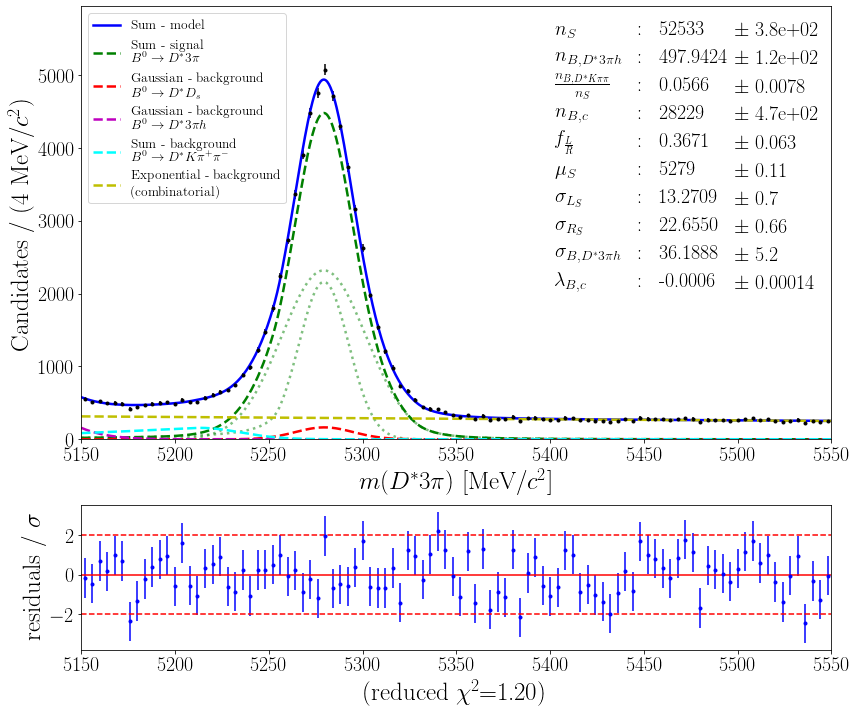

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt/B0_M_common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt_details_fit
Number of d.o.f. in the model:  10
Reduced chi2:  1.1967883225361025


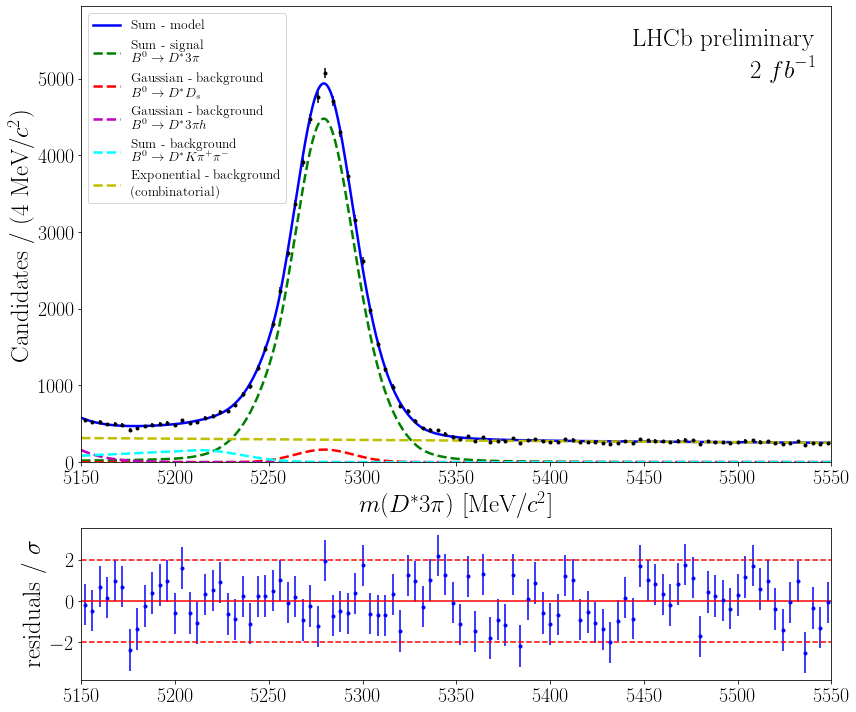

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt/B0_M_common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt_fit


(<Figure size 864x720 with 2 Axes>,
 <AxesSubplot:xlabel='$m$($D^{*}3\\pi$) [MeV/$c^2$]', ylabel='Candidates / (4 MeV/$c^2$)'>,
 <AxesSubplot:ylabel='residuals / $\\sigma$'>)

In [14]:
name_data_plot = name_data + '_details'
plot_hist_fit_particle(df,'B0_M', models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       params=params,name_params=name_params,
                       fontsize_leg=13.5, show_chi2=True,
                       colWidths=[0.06,0.01,0.05,0.06]
                      )
name_data_plot = name_data
plot_hist_fit_particle(df,'B0_M', models = [model,model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                       name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                      '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                       obs=obs, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot, name_folder=name_data,
                       colors=['b','g','r','m','cyan','y'],
                       fontsize_leg=13.5,
                       pos_text_LHC='right'
                      )

In [15]:
save_params(params,name_data, True, name_folder=name_data)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt/common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt_params.json


In [16]:
json_to_latex_table(name_data, name_data, name_params)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/tables/common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt/common_fixedTails_MC_cor_B0toDstDsWithmu2Fre_opt_params.tex
\begin{tabular}[t]{lc}
\hline
Variable &Fitted Value\\
\hline\hline
$f_{\frac{L}{R}}$&$0.367\pm0.063$\\
\hline
$\lambda_{B,c}$&$-0.00055\pm0.00014$\\
\hline
$\mu_S$&$5279.37\pm0.11$\\
\hline
$n_{B,c}$&$(2.823\pm0.047)\times 10^4$\\
\hline
$n_{B,D^*3\pi h}$&$(5.0\pm1.2)\times 10^2$\\
\hline
$n_S$&$(5.253\pm0.038)\times 10^4$\\
\hline
$\frac{n_{B,D^*K\pi\pi}}{n_S}$&$0.0566\pm0.0078$\\
\hline
$\sigma_{B,D^*3\pi h}$&$36.2\pm5.2$\\
\hline
$\sigma_{L_S}$&$13.27\pm0.70$\\
\hline
$\sigma_{R_S}$&$22.66\pm0.66$\\
\hline
\end{tabular}


In [3]:
fitted_params = retrieve_params(name_data, name_folder=name_data)

In [4]:
print(fitted_params)

{'frac': 0.3670786809806975, 'frac_err': 0.06301497464255881, 'lambda': -0.0005507868277186967, 'lambda_err': 0.00013848719821197826, 'mu': 5279.37471548757, 'mu_err': 0.10574661575631261, 'n_bkg': 28228.867271673455, 'n_bkg2': 497.94244947240645, 'n_bkg2_err': 118.67201767978541, 'n_bkg_err': 474.87243894255215, 'n_sig': 52533.2973182799, 'n_sig_err': 382.6139980629166, 'r_bkgK': 0.056564202490274794, 'r_bkgK_err': 0.0077681136266778165, 'sigma2': 36.18877685706683, 'sigma2_err': 5.242598286024353, 'sigmaL': 13.27092809255895, 'sigmaL_err': 0.7026603744618788, 'sigmaR': 22.65504764843002, 'sigmaR_err': 0.6631209954969501}
